In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func , inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
max_date = session.query(func.max(measurement.date)).first()[0]
print(max_date)

2017-08-23


In [13]:
min_date = session.query(func.min(measurement.date)).first()[0]
print(min_date)

2010-01-01


In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#print("Query Date: ", query_date)
one_year_perc = session.query(measurement.date, measurement.prcp).filter(measurement.date<"2017-08-23")\
.filter(measurement.date>"2016-08-23").order_by(measurement.date).all()
#pprint(one_year_perc)
# Save the query results as a Pandas DataFrame and set the index to the date column
prec_df = pd.DataFrame(one_year_perc, columns = ["Date", "Precipitation"])
prec_df.set_index("Date", inplace = True)

prec_df
# Sort the dataframe by date
sort_prec_df=prec_df.sort_values("Date",  ascending=True)
pprint(sort_prec_df)


            Precipitation
Date                     
2016-08-24           0.08
2016-08-24           2.15
2016-08-24           2.28
2016-08-24            NaN
2016-08-24           1.22
...                   ...
2017-08-21            NaN
2017-08-21           0.56
2017-08-22           0.00
2017-08-22           0.00
2017-08-22           0.50

[2219 rows x 1 columns]


In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

startdt=session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
query_startdate=dt.datetime.strptime(startdt,"%Y-%m-%d").date()
query_enddate=query_startdate-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

one_year_perc = session.query(measurement.date, measurement.prcp).filter(measurement.date<query_startdate)\
.filter(measurement.date>query_enddate).order_by(measurement.date).all()
#pprint(one_year_perc)
# Save the query results as a Pandas DataFrame and set the index to the date column
prec_df = pd.DataFrame(one_year_perc, columns = ["Date", "Precipitation"])
prec_df.set_index("Date", inplace = True)

prec_df
# Sort the dataframe by date
sort_prec_df=prec_df.sort_values("Date")
pprint(sort_prec_df)


            Precipitation
Date                     
2016-08-24           0.08
2016-08-24           2.15
2016-08-24           2.28
2016-08-24            NaN
2016-08-24           1.22
...                   ...
2017-08-21            NaN
2017-08-21           0.56
2017-08-22           0.00
2017-08-22           0.00
2017-08-22           0.50

[2219 rows x 1 columns]


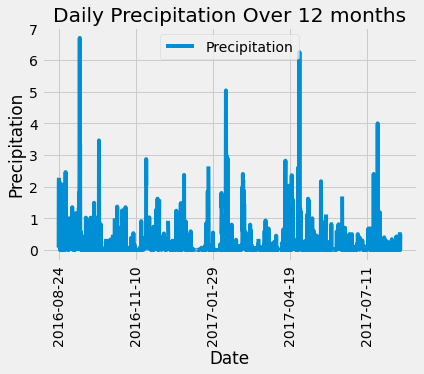

In [16]:


# Use Pandas Plotting with Matplotlip to plot the data
sort_prec_df.plot(y="Precipitation", use_index=True, rot=90)
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Daily Precipitation Over 12 months")



plt.savefig("precipitation.png")
plt.show()


In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sort_prec_df.describe()

,Precipitation
count,2011.000000
mean,0.176549
std,0.460667
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
stations_count = session.query(func.count(func.distinct(station.station))).first()[0]
stations_count

9

In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_active = session.query(measurement.station, func.count(measurement.id)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()
station_active


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
station_active = session.query(measurement.station, func.count(measurement.id)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).first()[0]
station_active

'USC00519281'

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#USC00519281 station is choosen to be the most active station from previous query
cal_temp_station=session.query(measurement.station,func.min(measurement.tobs), func.max(measurement.tobs),func.avg(measurement.tobs)).\
                 filter(measurement.station==station_active).all()
cal_temp_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [22]:
# Using the most active station id
# Query to get the start and end date
startdt=session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
query_startdate=dt.datetime.strptime(startdt,"%Y-%m-%d").date()
query_enddate=query_startdate-dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data_station=session.query(measurement.station, measurement.tobs).\
             filter(measurement.date<query_startdate).\
             filter(measurement.date>query_enddate).\
             filter(measurement.station==station_active).order_by(measurement.date).all()
tobs_data_station

[('USC00519281', 77.0),
 ('USC00519281', 80.0),
 ('USC00519281', 80.0),
 ('USC00519281', 75.0),
 ('USC00519281', 73.0),
 ('USC00519281', 78.0),
 ('USC00519281', 77.0),
 ('USC00519281', 78.0),
 ('USC00519281', 80.0),
 ('USC00519281', 80.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 73.0),
 ('USC00519281', 74.0),
 ('USC00519281', 80.0),
 ('USC00519281', 79.0),
 ('USC00519281', 77.0),
 ('USC00519281', 80.0),
 ('USC00519281', 76.0),
 ('USC00519281', 79.0),
 ('USC00519281', 75.0),
 ('USC00519281', 79.0),
 ('USC00519281', 78.0),
 ('USC00519281', 79.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 76.0),
 ('USC00519281', 74.0),
 ('USC00519281', 77.0),
 ('USC00519281', 78.0),
 ('USC00519281', 79.0),
 ('USC00519281', 79.0),
 ('USC00519281', 77.0),
 ('USC00519281', 80.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 77.0),
 ('USC00519281', 79.0),
 ('USC00519281', 79.0),
 ('USC00519281',

In [23]:
#Create a dataframe for the above query
tobs_df=pd.DataFrame(tobs_data_station, columns=["Station", "tobs"])
tobs_df

,Station,tobs
0,USC00519281,77.0
1,USC00519281,80.0
2,USC00519281,80.0
3,USC00519281,75.0
4,USC00519281,73.0
...,...,...
346,USC00519281,77.0
347,USC00519281,77.0
348,USC00519281,76.0
349,USC00519281,76.0


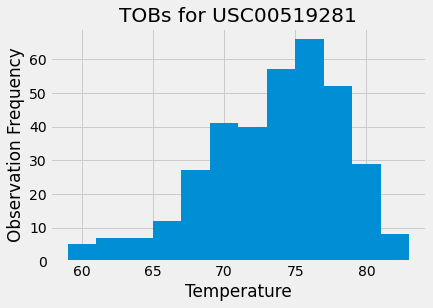

<Figure size 432x288 with 0 Axes>

In [24]:
#plot the histogram for the last 12 months of temperature observation data for this station
tobs_df["tobs"].hist(bins=12)
plt.title("TOBs for USC00519281")
plt.xlabel("Temperature")
plt.ylabel("Observation Frequency")
#Show and Save the plot
plt.show()
plt.savefig("hist_tobs.png")

# Close session

In [25]:
# Close Session
session.close()